# Minimierung der Tardiness jedes Produktionsauftrags

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
from src.utils.new_filter import *
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

# Solver Model
from src.models.lp import tardiness_scheduling as lp_tard_schedule
from src.models.lp import tardiness_rescheduling as lp_tard_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*15     # 15 min

# Simulation
simulation = ProductionSimulation(sigma = 0.15)

## I. Laden des fertigen Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [3]:
basic_data_path = get_path("data", "basic")
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [4]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
...,...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,520251.0,655,520389
7245,J25-7245,9,518089,518400,520296.0,540,519640
7246,J25-7246,6,518116,518400,520027.0,416,520157


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [5]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [6]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
7,J25-0007,5,925,1440,2930.0,496,2929
8,J25-0008,4,988,1440,2986.0,393,3541
9,J25-0009,7,1004,1440,3045.0,539,3578


In [7]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


### Scheduling

#### a) Summe der Tardiness minimieren

$$
\min \; \sum_{j \in J} \max(0,\; C_j - d_j)
$$


- $J$: Menge aller Jobs
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline von Job $j$
- $\max(0,\; C_j - d_j)$: Tardiness von Job $j$
- Die Summe betrachtet **nur verspätete Jobs** – Frühfertigungen zählen nicht.

**Erklärung:**
Diese Zielfunktion minimiert die **Gesamtheit aller Verspätungen**, d. h. die Summe aller positiven Abweichungen von den Deadlines.

In [8]:
# Scheduling
df_schedule = lp_tard_schedule.solve_jssp_sum(
    df_jssp_current, df_jobs_times_current, solver= "HiGHS",
    earliest_start_column = "Ready Time", msg=False, timeLimit=max_time, gapRel= 0.01
)
df_schedule


Solver-Informationen:
  Summe Tardiness         : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1392
  Anzahl Constraints      : 2576
  Laufzeit                : ~2 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J25-0000,8,0,M00,76,79,1440,3660,2645.0,2721.0,0.0
1,J25-0000,8,1,M01,69,79,1440,3660,2721.0,2790.0,0.0
2,J25-0000,8,2,M03,76,79,1440,3660,3026.0,3102.0,0.0
3,J25-0000,8,3,M05,51,79,1440,3660,3102.0,3153.0,0.0
4,J25-0000,8,4,M02,85,79,1440,3660,3191.0,3276.0,0.0
5,J25-0000,8,5,M09,11,79,1440,3660,3303.0,3314.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
154,J25-0015,5,4,M08,48,1436,1440,2981,1925.0,1973.0,0.0
155,J25-0015,5,5,M09,72,1436,1440,2981,1973.0,2045.0,0.0
156,J25-0015,5,6,M00,47,1436,1440,2981,2045.0,2092.0,0.0


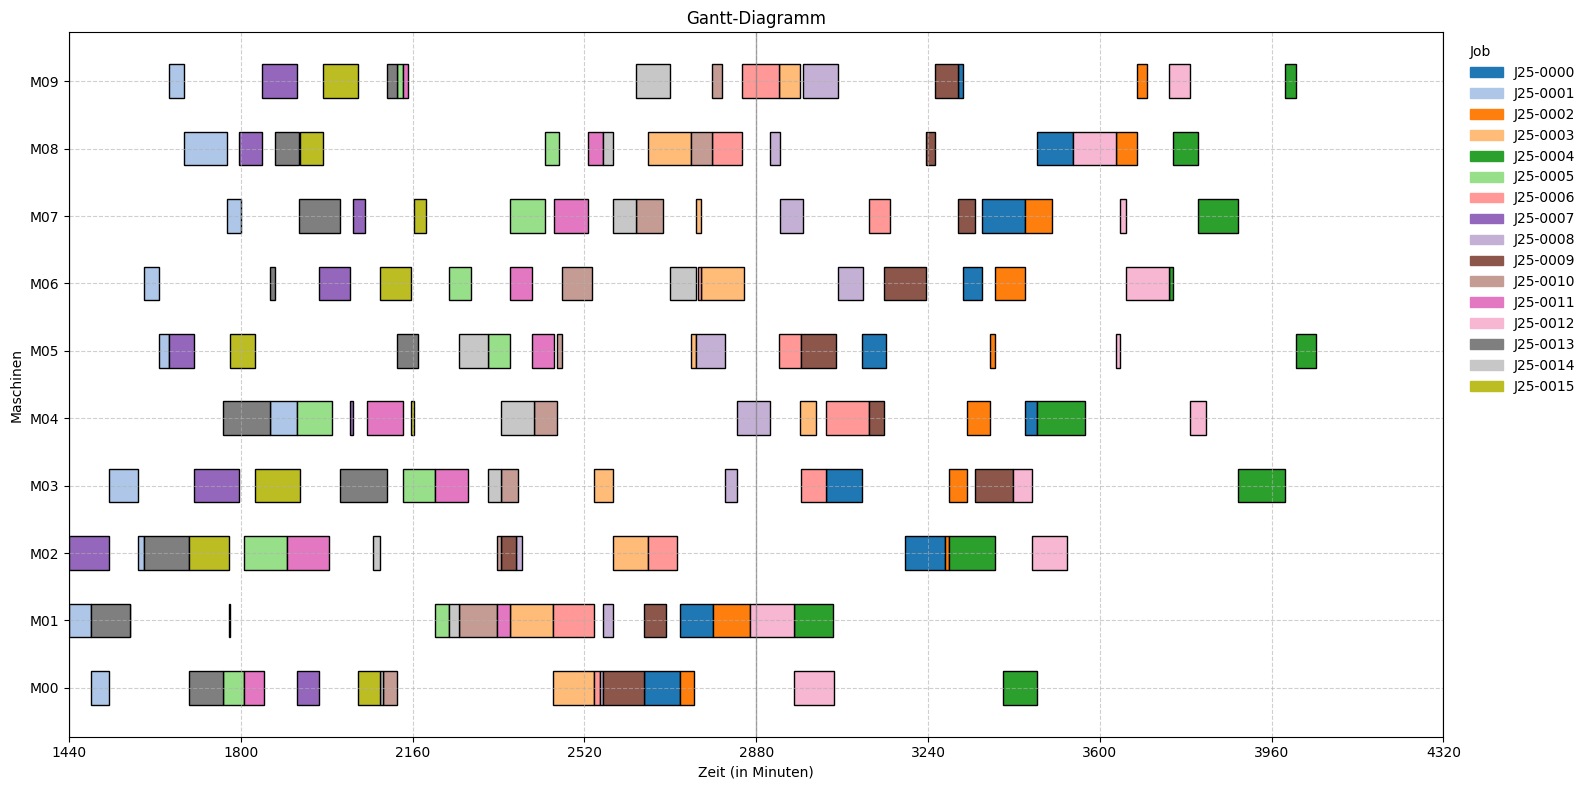

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [9]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

### Simulation

In [10]:
simulation.run(dframe_schedule_plan= df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0001 started on M01
[Day 1 00:00:00] Job J25-0007 started on M02
[Day 1 00:54:00] Job J25-0001 finished on M01 (after 54 minutes)
[Day 1 00:54:00] Job J25-0013 started on M01
[Day 1 00:54:00] Job J25-0001 started on M00
[Day 1 01:27:00] Job J25-0001 finished on M00 (after 33 minutes)
[Day 1 01:27:00] Job J25-0001 started on M03
[Day 1 01:28:00] Job J25-0007 finished on M02 (after 88 minutes)
[Day 1 02:12:00] Job J25-0013 finished on M01 (after 78 minutes)
[Day 1 02:12:00] Job J25-0007 started on M01
[Day 1 02:14:00] Job J25-0007 finished on M01 (after 02 minutes)
[Day 1 02:37:00] Job J25-0013 started on M02
[Day 1 02:39:00] Job J25-0001 finished on M03 (after 72 minutes)
[Day 1 03:30:00] Job J25-0007 started on M05
[Day 1 04:08:00] Job J25-0013 finished on M02 (after 91 minutes)
[Day 1 04:08:00] Job J25-0001 started on M02
[Day 1 04:12:00] Job J25-0013 started on M00
[Day 1 04:24:00] Job J25-0001 finished on M02 (after 16 minutes)
[Day 1 04:24:00] Job J25-0015 

In [11]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Routing_ID,Job,Operation,Machine,Arrival,Start,Processing Time,End
0,8,J25-0000,0,M00,79,2655.0,83.0,2738.0
1,8,J25-0000,1,M01,79,2738.0,73.0,2811.0
2,6,J25-0001,0,M01,129,1440.0,54.0,1494.0
3,6,J25-0001,1,M00,129,1494.0,33.0,1527.0
4,6,J25-0001,2,M03,129,1527.0,72.0,1599.0
5,6,J25-0001,3,M02,129,1688.0,16.0,1704.0
...,...,...,...,...,...,...,...,...
98,5,J25-0015,4,M08,1436,1954.0,66.0,2020.0
99,5,J25-0015,5,M09,1436,2020.0,71.0,2091.0
100,5,J25-0015,6,M00,1436,2091.0,40.0,2131.0


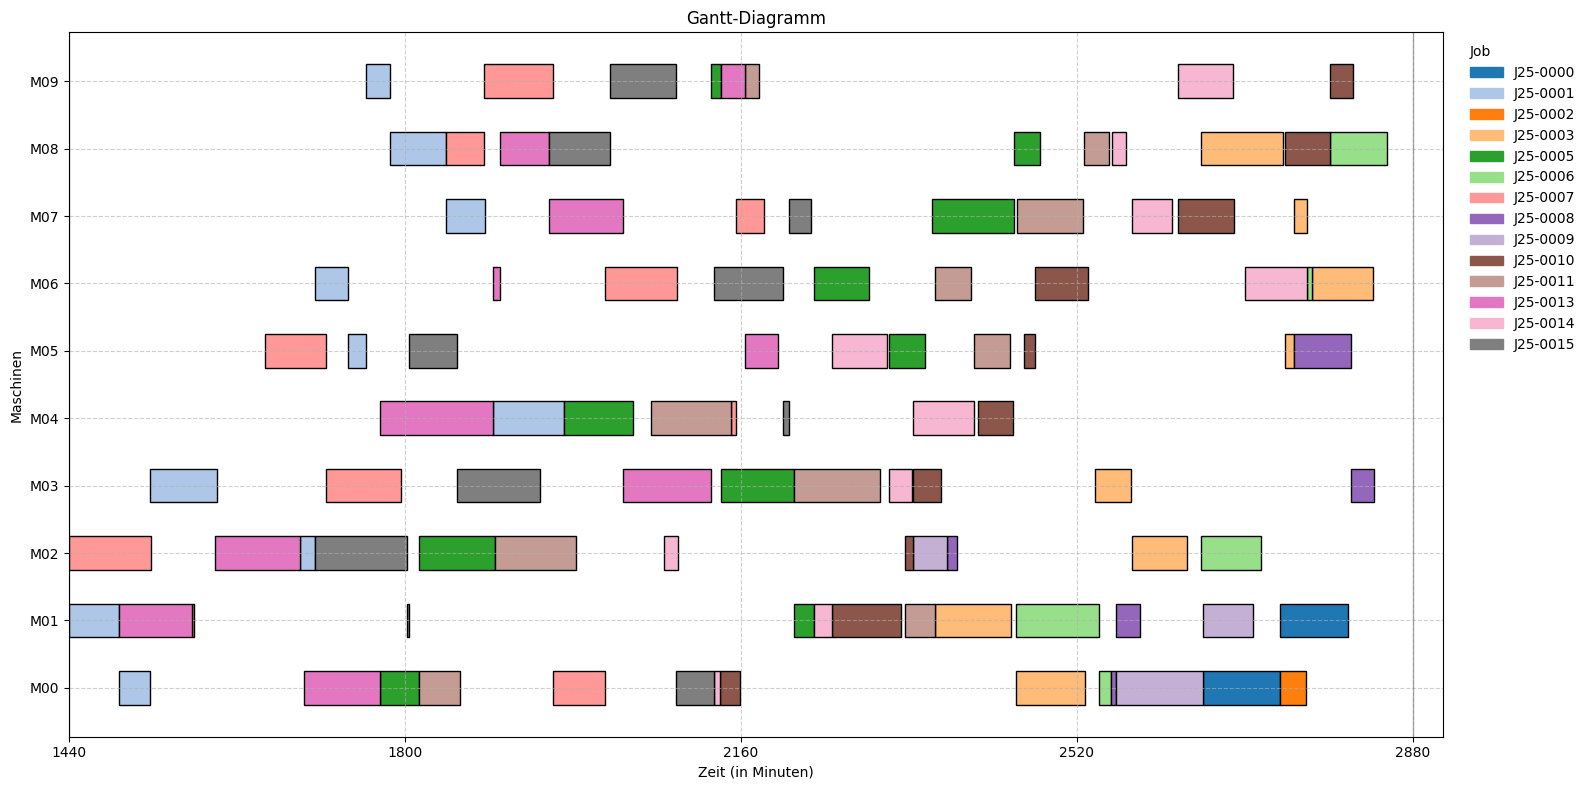

In [12]:
show.plot_gantt(df_execution, perspective="Machine")

In [13]:
df_active = simulation.get_active_operations_df()
df_active

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0002,1,M01,198,2811.0,78,83.0,2889.0,2894.0
1,J25-0006,5,M09,790,2853.0,76,76.0,2929.0,2929.0
2,J25-0008,5,M04,988,2840.0,69,61.0,2909.0,2901.0


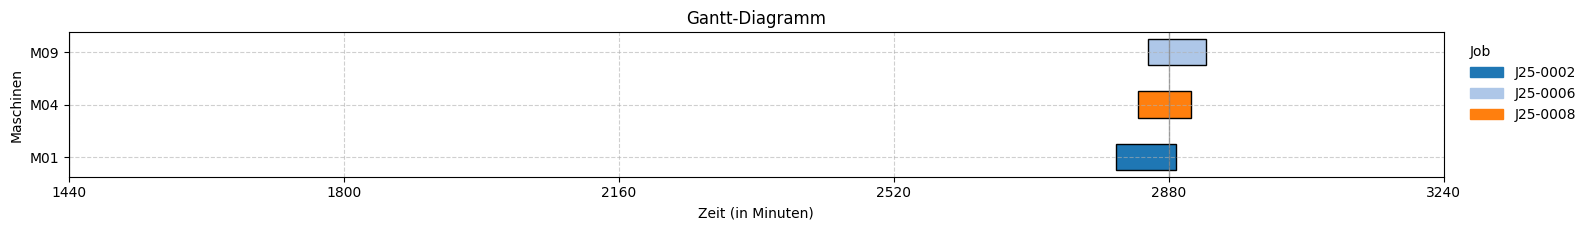

In [14]:
show.plot_gantt(df_active, perspective="Machine", duration_column="Planned Duration")

In [15]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J25-0000,8,2,M03,76,79,1440,3660,3026.0,3102.0,0.0
1,J25-0000,8,3,M05,51,79,1440,3660,3102.0,3153.0,0.0
2,J25-0000,8,4,M02,85,79,1440,3660,3191.0,3276.0,0.0
3,J25-0000,8,5,M09,11,79,1440,3660,3303.0,3314.0,0.0
4,J25-0000,8,6,M06,40,79,1440,3660,3314.0,3354.0,0.0
5,J25-0000,8,7,M07,89,79,1440,3660,3354.0,3443.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
47,J25-0012,2,4,M08,90,1103,1440,4385,3543.0,3633.0,0.0
48,J25-0012,2,5,M05,10,1103,1440,4385,3633.0,3643.0,0.0
49,J25-0012,2,6,M07,12,1103,1440,4385,3643.0,3655.0,0.0


#### b) größte Tardiness minimieren

$$
\min \; \max_{j \in J} \left( \max(0,\; C_j - d_j) \right)
$$


- $J$: Menge aller Jobs
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline von Job $j$
- $\max(0,\; C_j - d_j)$: Tardiness des Jobs $j$
- Die äußere $\max$-Funktion bestimmt den Job mit der **größten Verspätung**

**Erklärung:**
Diese Zielfunktion minimiert die **schlimmste Deadline-Überschreitung** unter allen Jobs. Frühfertigungen fließen dabei **nicht** ein.

In [16]:
# Scheduling
df_schedule_b = lp_tard_schedule.solve_jssp_max(
    df_jssp_current, df_jobs_times_current, solver="HiGHS",
    earliest_start_column = "Ready Time", msg=False, timeLimit=max_time, gapRel=0.01)
df_schedule_b


Solver-Informationen:
  Maximale Tardiness      : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1393
  Anzahl Constraints      : 2592
  Laufzeit                : ~2 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J25-0000,8,0,M00,76,79,1440,3660,2554.0,2630.0,0.0
1,J25-0000,8,1,M01,69,79,1440,3660,2762.0,2831.0,0.0
2,J25-0000,8,2,M03,76,79,1440,3660,2987.0,3063.0,0.0
3,J25-0000,8,3,M05,51,79,1440,3660,3063.0,3114.0,0.0
4,J25-0000,8,4,M02,85,79,1440,3660,3114.0,3199.0,0.0
5,J25-0000,8,5,M09,11,79,1440,3660,3312.0,3323.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
154,J25-0015,5,4,M08,48,1436,1440,2981,2020.0,2068.0,0.0
155,J25-0015,5,5,M09,72,1436,1440,2981,2068.0,2140.0,0.0
156,J25-0015,5,6,M00,47,1436,1440,2981,2140.0,2187.0,0.0


## Tag 2
- hier findet die Neuplanung statt, also das Scheduling mit bestimmter Berücksichtigung der Simulation

In [17]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [18]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
6,J25-0006,9,790,1440,2905.0,540,3539
8,J25-0008,4,988,1440,2986.0,393,3541
...,...,...,...,...,...,...,...
32,J25-0032,6,2654,2880,4856.0,416,3881
33,J25-0033,2,2660,2880,5305.0,568,6738
34,J25-0034,8,2715,2880,5271.0,597,6387


In [19]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_times_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
6,J25-0000,8,6,M06,40
7,J25-0000,8,7,M07,89
...,...,...,...,...,...
374,J25-0037,7,4,M04,32
375,J25-0037,7,5,M06,88
376,J25-0037,7,6,M08,19


### a) einfache Neuplanung
- berücksichtigt lediglich die aktiven Arbeitsgänge (Operationen)

In [ ]:
df_schedule_simple = lp_tard_reschedule.solve_jssp_sum_with_fixed_ops(
    df_jssp_current, df_jobs_times_current, df_active,
    reschedule_start = 1440, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_simple

BigM: 9000


In [ ]:
df_temp =  df_schedule_simple

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

In [ ]:
df_reschedule = df_schedule_simple

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### b) Neuplanung mit zusätzlich Minimierung der Planabweichung für die zuvor geplante Arbeitsgänge

In [ ]:
df_schedule_devpen = lp_tard_reschedule.solve_jssp_sum_with_devpen(
    df_jssp_current, df_jobs_times_current, df_active,
    df_original_plan = df_schedule,                     # prev. Plan
    r = 0.60,                                           # 60% Flowtime, 40% Abweichung
    reschedule_start = day_start, solver= "HiGHS",
    msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_devpen

In [ ]:
df_temp =  df_schedule_devpen

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

In [ ]:
df_reschedule = df_schedule_devpen

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### Simulation

In [ ]:
simulation.run(dframe_schedule_plan = df_schedule_devpen, start_time = day_start, end_time = day_end)

In [ ]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

In [ ]:
show.plot_gantt(df_execution2, perspective="Machine")

In [ ]:
df_active2 = simulation.get_active_operations_df()
df_active2

In [ ]:
df_not_started2 = simulation.get_not_started_operations_df(df_schedule)
df_not_started2

#### Check der Bedingungen des kombinierten Datensatzes aus den beiden Simulationsdaten

In [ ]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)